## **Fine-tuning BERT for named-entity recognition**

In this notebook, we are going to use **BertForTokenClassification** which is included in the [Transformers library](https://github.com/huggingface/transformers) by HuggingFace. This model has BERT as its base architecture, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. Named entity recognition is typically treated as a token classification problem, so that's what we are going to use it for.

This tutorial uses the idea of **transfer learning**, i.e. first pretraining a large neural network in an unsupervised way, and then fine-tuning that neural network on a task of interest. In this case, BERT is a neural network pretrained on 2 tasks: masked language modeling and next sentence prediction. Now, we are going to fine-tune this network on a NER dataset. Fine-tuning is supervised learning, so this means we will need a labeled dataset.

If you want to know more about BERT, I suggest the following resources:
* the original [paper](https://arxiv.org/abs/1810.04805)
* Jay Allamar's [blog post](http://jalammar.github.io/illustrated-bert/) as well as his [tutorial](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
* Chris Mccormick's [Youtube channel](https://www.youtube.com/channel/UCoRX98PLOsaN8PtekB9kWrw)
* Abbishek Kumar Mishra's [Youtube channel](https://www.youtube.com/user/abhisheksvnit)

The following notebook largely follows the same structure as the tutorials by Abhishek Kumar Mishra. For his tutorials on the Transformers library, see his [Github repository](https://github.com/abhimishra91/transformers-tutorials).

NOTE: this notebook assumes basic knowledge about deep learning, BERT, and native PyTorch. If you want to learn more Python, deep learning and PyTorch, I highly recommend cs231n by Stanford University and the FastAI course by Jeremy Howard et al. Both are freely available on the web.  

Now, let's move on to the real stuff!

#### **Importing Python Libraries and preparing the environment**

This notebook assumes that you have the following libraries installed:
* pandas
* numpy
* sklearn
* pytorch
* transformers
* seqeval

As we are running this in Google Colab, the only libraries we need to additionally install are transformers and seqeval (GPU version):

In [ ]:
!pip install transformers seqeval[gpu]

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth',1000)
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AutoTokenizer, AutoModelForTokenClassification

As deep learning can be accellerated a lot using a GPU instead of a CPU, make sure you can run this notebook in a GPU runtime (which Google Colab provides for free! - check "Runtime" - "Change runtime type" - and set the hardware accelerator to "GPU").

We can set the default device to GPU using the following code (if it prints "cuda", it means the GPU has been recognized):

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Downloading and preprocessing the data**
Named entity recognition (NER) uses a specific annotation scheme, which is defined (at least for European languages) at the *word* level. An annotation scheme that is widely used is called **[IOB-tagging](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging))**, which stands for Inside-Outside-Beginning. Each tag indicates whether the corresponding word is *inside*, *outside* or at the *beginning* of a specific named entity. The reason this is used is because named entities usually comprise more than 1 word.

Let's have a look at an example. If you have a sentence like "Barack Obama was born in Hawaï", then the corresponding tags would be   [B-PERS, I-PERS, O, O, O, B-GEO]. B-PERS means that the word "Barack" is the beginning of a person, I-PERS means that the word "Obama" is inside a person, "O" means that the word "was" is outside a named entity, and so on. So one typically has as many tags as there are words in a sentence.

So if you want to train a deep learning model for NER, it requires that you have your data in this IOB format (or similar formats such as [BILOU](https://stackoverflow.com/questions/17116446/what-do-the-bilou-tags-mean-in-named-entity-recognition)). There exist many annotation tools which let you create these kind of annotations automatically (such as Spacy's [Prodigy](https://prodi.gy/), [Tagtog](https://docs.tagtog.net/) or [Doccano](https://github.com/doccano/doccano)). You can also use Spacy's [biluo_tags_from_offsets](https://spacy.io/api/goldparse#biluo_tags_from_offsets) function to convert annotations at the character level to IOB format.

Here, we will use a NER dataset from [Kaggle](https://www.kaggle.com/namanj27/ner-dataset) that is already in IOB format. One has to go to this web page, download the dataset, unzip it, and upload the csv file to this notebook. Let's print out the first few rows of this csv file:

In [ ]:
data = pd.read_csv("oversampled_file.csv")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 3973,SQL,NONE,B-Remote/Local
1,Sentence: 5335,5.8,NONE,B-Risk
2,Sentence: 6564,network,NONE,I-Vulnerability_Type
3,Sentence: 3005,2017-11-15,NONE,B-Published_dates
4,Sentence: 1790,passwords.,NONE,O


Let's check how many sentences and words (and corresponding tags) there are in this dataset:

In [ ]:
data.count()

Sentence #    156794
Word          156631
POS           156794
Tag           156794
dtype: int64

As we can see, there are approximately 48,000 sentences in the dataset, comprising more than 1 million words and tags (quite huge!). This corresponds to approximately 20 words per sentence.

Let's have a look at the different NER tags, and their frequency:

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 21


O                       26186
I-Impact                20200
B-Vulnerability_Type    11700
B-CVE                   10476
B-Vendor                 9642
B-Impact                 8810
B-Product                8716
B-Published_dates        8645
B-Risk                   8505
B-Remote/Local           8404
B-Version_Number         8368
B-Host_Information       8167
I-Vulnerability_Type     7061
I-Product                3696
I-Host_Information       2222
I-Risk                   1467
I-Published_dates        1219
I-Version_Number         1051
I-CVE                     992
I-Remote/Local            747
I-Vendor                  520
Name: Tag, dtype: int64

There are 8 category tags, each with a "beginning" and "inside" variant, and the "outside" tag. It is not really clear what these tags mean - "geo" probably stands for geographical entity, "gpe" for geopolitical entity, and so on. They do not seem to correspond with what the publisher says on Kaggle. Some tags seem to be underrepresented. Let's print them by frequency (highest to lowest):

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('Imp', 29010), ('Vul', 18761), ('Pro', 12412), ('CVE', 11468), ('Hos', 10389), ('Ven', 10162), ('Ris', 9972), ('Pub', 9864), ('Ver', 9419), ('Rem', 9151)]


Let's remove "art", "eve" and "nat" named entities, as performance on them will probably be not comparable to the other named entities.

In [ ]:
entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 3973,SQL,NONE,B-Remote/Local
1,Sentence: 5335,5.8,NONE,B-Risk
2,Sentence: 6564,network,NONE,I-Vulnerability_Type
3,Sentence: 3005,2017-11-15,NONE,B-Published_dates
4,Sentence: 1790,passwords.,NONE,O


Now, we have to ask ourself the question: what is a training example in the case of NER, which is provided in a single forward pass? A training example is typically a **sentence**, with corresponding IOB tags. Let's group the words and corresponding tags by sentence:

In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 3973,SQL,NONE,B-Remote/Local
1,Sentence: 5335,5.8,NONE,B-Risk
2,Sentence: 6564,network,NONE,I-Vulnerability_Type
3,Sentence: 3005,2017-11-15,NONE,B-Published_dates
4,Sentence: 1790,passwords.,NONE,O


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 3973,SQL,NONE,B-Remote/Local,SQL ---------------------------------------------------------------------------- SQL Command SQL CommandPost SQL SQL Command the SQL is Command CommandPost SQL SQL web Command SQL SQL investigating. by Command ---------------------------------------------------------------------------- CommandPost Command CommandPost Command CommandPost Remote Command -------------------------------------------------------------------------------- SQL of SQL SQL Command Command SQL SQL Command to Command CommandPost CommandPost Remote web CommandPost SQL ---------------------------------------------------------------------------- CommandPost ---------------------------------------------------------------------------- SQL injection** appliance Remote appliance Remote Command Remote this Command Command CommandPost SQL Command I -------------------------------------------------------------------------------- Command SQL Command Command -----------------------------------------------------------------...,"B-Remote/Local,B-CVE,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,B-Remote/Local,O,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,B-Product,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,O,B-Remote/Local,B-CVE,B-Vendor,B-Remote/Local,B-Vendor,B-Remote/Local,B-Vendor,B-Vulnerability_Type,B-Remote/Local,B-CVE,B-Remote/Local,O,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,B-Remote/Local,B-Vendor,B-Vendor,B-Vulnerability_Type,B-Product,B-Vendor,B-Remote/Local,B-CVE,B-Vendor,B-CVE,B-Remote/Local,I-Vulnerability_Type,B-Product,B-Vulnerability_Type,B-Product,B-Vulnerability_Type,B-Remote/Local,B-Vulnerability_Type,O,B-Remote/Local,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,O,B-CVE,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-CVE,O,B-Remote/Local,B-Vulnerability_Type,B-Remote/Local,B-Remote/Local,B-Vendor,B-Vendor,I-Vulnerability_Type,B-Rem..."
1,Sentence: 5335,5.8,NONE,B-Risk,5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8,"B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk"
2,Sentence: 6564,network,NONE,I-Vulnerability_Type,network adjacent 8.6 **CVSSv3 CVE-2021-20145 **CVSSv3 **CVSSv3 Score:** CVE-2021-20145 Base CVE-2021-20145 **CVSSv3 access adjacent adjacent **CVSSv3 **CVSSv3 Unprotected CVE-2021-20145 **CVSSv3 **CVSSv3 **CVSSv3,"I-Vulnerability_Type,B-Vulnerability_Type,I-Risk,B-Risk,B-CVE,B-Risk,B-Risk,I-Risk,B-CVE,I-Risk,B-CVE,B-Risk,I-Vulnerability_Type,B-Vulnerability_Type,B-Vulnerability_Type,B-Risk,B-Risk,O,B-CVE,B-Risk,B-Risk,B-Risk"
3,Sentence: 3005,2017-11-15,NONE,B-Published_dates,"2017-11-15 WKE2.094.277A01 FiberHome FiberHome RP2602: HG6245D 2017-11-15 Hardware 2018-04-13 HG6245D 2018-04-13 routers RP2602: FiberHome FiberHome 2017-11-15 2018-04-13 FiberHome 2018-04-13 RP2602: routers version firmware FiberHome HG6245D, FiberHome 2017-11-15 FiberHome 2018-04-13 HG6245D FiberHome FiberHome America HG6245D FiberHome Technologies 2017-11-15 FiberHome FiberHome RP2602: HG6245D, FiberHome 2017-11-15 vendor 2017-11-15 2018-04-13 HG6245D : HG6245D vulnerabilities FiberHome FiberHome FiberHome FiberHome FiberHome FiberHome routers FiberHome FiberHome FiberHome 2018-04-13 FiberHome","B-Published_dates,I-Host_Information,B-Vendor,B-Vendor,B-Version_Number,B-Product,B-Published_dates,B-Host_Information,B-Published_dates,B-Product,B-Published_dates,I-Product,B-Version_Number,B-Vendor,B-Vendor,B-Published_dates,B-Published_dates,B-Vendor,B-Published_dates,B-Version_Number,I-Product,I-Host_Information,O,B-Vendor,B-Product,B-Vendor,B-Published_dates,B-Vendor,B-Published_dates,B-Product,B-Vendor,B-Vendor,O,B-Product,B-Vendor,I-Vendor,B-Published_dates,B-Vendor,B-Vendor,B-Version_Number,B-Product,B-Vendor,B-Published_dates,O,B-Published_dates,B-Published_dates,B-Product,I-Host_Information,B-Product,O,B-Vendor,B-Vendor

Let's have a look at the different NER tags.

We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [ ]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}
label2id

{'B-Remote/Local': 0,
 'B-Risk': 1,
 'I-Vulnerability_Type': 2,
 'B-Published_dates': 3,
 'O': 4,
 'B-CVE': 5,
 'B-Product': 6,
 'B-Impact': 7,
 'B-Version_Number': 8,
 'B-Vulnerability_Type': 9,
 'I-Impact': 10,
 'I-Version_Number': 11,
 'B-Host_Information': 12,
 'B-Vendor': 13,
 'I-Product': 14,
 'I-Published_dates': 15,
 'I-Host_Information': 16,
 'I-Risk': 17,
 'I-CVE': 18,
 'I-Remote/Local': 19,
 'I-Vendor': 20}

As we can see, there are now only 10 different tags.

Let's only keep the "sentence" and "word_labels" columns, and drop duplicates:

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,SQL ---------------------------------------------------------------------------- SQL Command SQL CommandPost SQL SQL Command the SQL is Command CommandPost SQL SQL web Command SQL SQL investigating. by Command ---------------------------------------------------------------------------- CommandPost Command CommandPost Command CommandPost Remote Command -------------------------------------------------------------------------------- SQL of SQL SQL Command Command SQL SQL Command to Command CommandPost CommandPost Remote web CommandPost SQL ---------------------------------------------------------------------------- CommandPost ---------------------------------------------------------------------------- SQL injection** appliance Remote appliance Remote Command Remote this Command Command CommandPost SQL Command I -------------------------------------------------------------------------------- Command SQL Command Command -----------------------------------------------------------------...,"B-Remote/Local,B-CVE,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,B-Remote/Local,O,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,B-Product,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,O,B-Remote/Local,B-CVE,B-Vendor,B-Remote/Local,B-Vendor,B-Remote/Local,B-Vendor,B-Vulnerability_Type,B-Remote/Local,B-CVE,B-Remote/Local,O,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,O,B-Remote/Local,B-Vendor,B-Vendor,B-Vulnerability_Type,B-Product,B-Vendor,B-Remote/Local,B-CVE,B-Vendor,B-CVE,B-Remote/Local,I-Vulnerability_Type,B-Product,B-Vulnerability_Type,B-Product,B-Vulnerability_Type,B-Remote/Local,B-Vulnerability_Type,O,B-Remote/Local,B-Remote/Local,B-Vendor,B-Remote/Local,B-Remote/Local,O,B-CVE,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-Remote/Local,B-CVE,O,B-Remote/Local,B-Vulnerability_Type,B-Remote/Local,B-Remote/Local,B-Vendor,B-Vendor,I-Vulnerability_Type,B-Rem..."
1,5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8 5.8,"B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk,B-Risk"
2,network adjacent 8.6 **CVSSv3 CVE-2021-20145 **CVSSv3 **CVSSv3 Score:** CVE-2021-20145 Base CVE-2021-20145 **CVSSv3 access adjacent adjacent **CVSSv3 **CVSSv3 Unprotected CVE-2021-20145 **CVSSv3 **CVSSv3 **CVSSv3,"I-Vulnerability_Type,B-Vulnerability_Type,I-Risk,B-Risk,B-CVE,B-Risk,B-Risk,I-Risk,B-CVE,I-Risk,B-CVE,B-Risk,I-Vulnerability_Type,B-Vulnerability_Type,B-Vulnerability_Type,B-Risk,B-Risk,O,B-CVE,B-Risk,B-Risk,B-Risk"
3,"2017-11-15 WKE2.094.277A01 FiberHome FiberHome RP2602: HG6245D 2017-11-15 Hardware 2018-04-13 HG6245D 2018-04-13 routers RP2602: FiberHome FiberHome 2017-11-15 2018-04-13 FiberHome 2018-04-13 RP2602: routers version firmware FiberHome HG6245D, FiberHome 2017-11-15 FiberHome 2018-04-13 HG6245D FiberHome FiberHome America HG6245D FiberHome Technologies 2017-11-15 FiberHome FiberHome RP2602: HG6245D, FiberHome 2017-11-15 vendor 2017-11-15 2018-04-13 HG6245D : HG6245D vulnerabilities FiberHome FiberHome FiberHome FiberHome FiberHome FiberHome routers FiberHome FiberHome FiberHome 2018-04-13 FiberHome","B-Published_dates,I-Host_Information,B-Vendor,B-Vendor,B-Version_Number,B-Product,B-Published_dates,B-Host_Information,B-Published_dates,B-Product,B-Published_dates,I-Product,B-Version_Number,B-Vendor,B-Vendor,B-Published_dates,B-Published_dates,B-Vendor,B-Published_dates,B-Version_Number,I-Product,I-Host_Information,O,B-Vendor,B-Product,B-Vendor,B-Published_dates,B-Vendor,B-Published_dates,B-Product,B-Vendor,B-Vendor,O,B-Product,B-Vendor,I-Vendor,B-Published_dates,B-Vendor,B-Vendor,B-Version_Number,B-Product,B-Vendor,B-Published_dates,O,B-Published_dates,B-Published_dates,B-Product,I-Host_Information,B-Product,O,B-Vendor,B-Vendor,B-Vendor,B-Vendor,B-Vendor,B-Vendor,I-Product,B-Vendor,B-Vendor,B-Vendor,B-Published_dates,B-Vendor"
4,passwords.,O


In [ ]:
len(data)

7565

Let's verify that a random sentence and its corresponding tags are correct:

In [ ]:
data.iloc[41].sentence

'CVE-2021-40400 cryptographic Hard February CVE 2019-10-22 CVE-2021-40400 2019-10-22 2019-10-22 2020-02-24 2020-02-24 2020-02-24 CVE-2021-40400 Gerbv 0x18($v1) read Hard 27c20018 2.7.0 = February February keys = Hurd 2019-10-22 ``` = lwl 2.7.0 read local out-of-bounds = $sp 2022 2.7.0 February afc20034 244377b8 $a0, CVE Number 2020-02-24 [0x1f] 2020-02-24 [0x6] February 8fc60044 2020-02-24 coded Release 2.7.0 RS-274X Gerbv Hard vulnerability out-of-bounds aperture CVE vulnerability CVE Gerbv CVE-2021-40400 2020-02-24 out-of-bounds = 2019-10-22 key February 28, 2019-10-22 out-of-bounds February out-of-bounds out-of-bounds Gerbv 2019-10-22'

In [ ]:
data.iloc[41].word_labels

#### **Preparing the dataset and dataloader**

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model. Let's start by defining some key variables that will be used later on in the training/evaluation process:

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = AutoTokenizer.from_pretrained('jackaduma/SecBERT')

A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then we will have to propagate the word’s original label to all of its wordpieces: "b-gpe", "b-gpe", "b-gpe". The model should be able to produce the correct labels for each individual wordpiece. The function below (taken from [here](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L118)) implements this.






In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

Note that this is a **design decision**. You could also decide to only label the first wordpiece of each word and let the model only learn this (this is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063)). Another design decision could be to give the first wordpiece of each word the original word label, and then use the label “X” for all subsequent subwords of that word.

All of them lead to good performance.

Next, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors). Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above.

For more information about BERT's inputs, see [here](https://huggingface.co/transformers/glossary.html).  

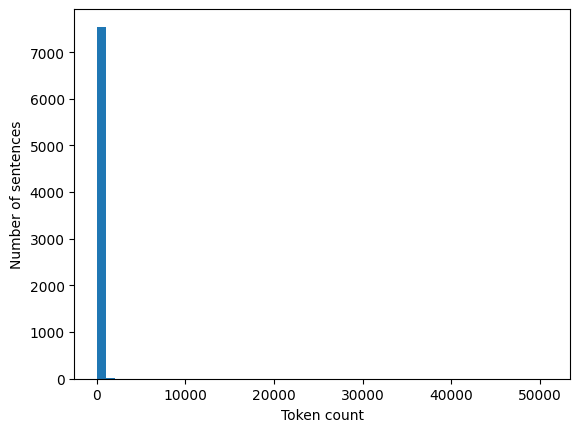

In [ ]:
# ADDED 10/30
# Code to check distribution of token lengths in the dataset
token_lengths = []

for _, row in data.iterrows():
    tokenized_sentence, _ = tokenize_and_preserve_labels(row['sentence'], row['word_labels'], tokenizer)
    token_lengths.append(len(tokenized_sentence))

# Now, let's visualize the distribution
import matplotlib.pyplot as plt

plt.hist(token_lengths, bins=50)
plt.xlabel('Token count')
plt.ylabel('Number of sentences')
plt.show()

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (7565, 2)
TRAIN Dataset: (6052, 2)
TEST Dataset: (1513, 2)


Let's have a look at the first training example:

In [ ]:
training_set[0]

{'ids': tensor([    2,    37,  5992,    39,    12,  3771,    30,    19,    19,  5992,
            18, 34861, 12258,  3815,    18,  1440,    13,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

Let's verify that the input ids and corresponding targets are correct:

In [ ]:
training_set[0]["ids"]

tensor([    2,    37,  5992,    39,    12,  3771,    30,    19,    19,  5992,
           18, 34861, 12258,  3815,    18,  1440,    13,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
[           O
training    O
]           O
(           O
https       O
:           O
/           O
/           O
training    O
.           O
sensi       O
##ola       O
##bs        O
.           O
com         O
)           O
[SEP]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O


Now, let's define the corresponding PyTorch dataloaders:

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Defining the model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('jackaduma/SecBERT',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

#### **Training the model**

Before training the model, let's perform a sanity check, which I learned thanks to Andrej Karpathy's wonderful [cs231n course](http://cs231n.stanford.edu/) at Stanford (see also his [blog post about debugging neural networks](http://karpathy.github.io/2019/04/25/recipe/)). The initial loss of your model should be close to -ln(1/number of classes) = -ln(1/17) = 2.83.

Why? Because we are using cross entropy loss. The cross entropy loss is defined as -ln(probability score of the model for the correct class). In the beginning, the weights are random, so the probability distribution for all of the classes for a given token will be uniform, meaning that the probability for the correct class will be near 1/17. The loss for a given token will thus be -ln(1/17). As PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (which is used by `BertForTokenClassification`) uses *mean reduction* by default, it will compute the mean loss for each of the tokens in the sequence (in other words, for all of the 512 tokens). The mean of 512 times -log(1/17) is, you guessed it, -log(1/17).  

Let's verify this:



In [ ]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.8713, device='cuda:0', grad_fn=<NllLossBackward0>)

This looks good. Let's also verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 21])

Next, we define the optimizer. Here, we are just going to use Adam with a default learning rate. One can also decide to use more advanced ones such as AdamW (Adam with weight decay fix), which is [included](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) in the Transformers repository, and a learning rate scheduler, but we are not going to do that here.

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Add a learning rate scheduler
from transformers import get_linear_schedule_with_warmup

total_steps = len(training_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Now let's define a regular PyTorch training function. It is partly based on [a really good repository about multilingual NER](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344).

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
epoch_accuracies = []

def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ADDED 10/30
    scheduler.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

    epoch_accuracies.append(tr_accuracy)

And let's train the model!

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 3.4605276584625244
Training loss per 100 training steps: 1.270288771036828
Training loss per 100 training steps: 1.0748207843422297
Training loss per 100 training steps: 0.9422746505402647
Training loss per 100 training steps: 0.8767182255660804
Training loss per 100 training steps: 0.8108804964287553
Training loss per 100 training steps: 0.7720702892160058
Training loss per 100 training steps: 0.7428560092003641
Training loss per 100 training steps: 0.7133421647675178
Training loss per 100 training steps: 0.6985029629808949
Training loss per 100 training steps: 0.6874896914704697
Training loss per 100 training steps: 0.6689085739306923
Training loss per 100 training steps: 0.6532973784683497
Training loss per 100 training steps: 0.6389241229762809
Training loss per 100 training steps: 0.623725058746223
Training loss per 100 training steps: 0.6150685672900782
Training loss epoch: 0.6144612407445986
Training accuracy epoch: 0.58458

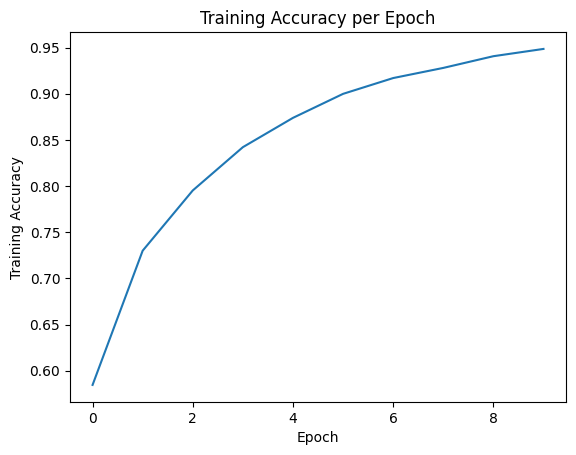

In [ ]:
# After all epochs, plot the accuracies:
plt.plot(epoch_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.show()

#### **Evaluating the model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is 20% of the data). Note that here, no gradient updates are performed, the model just outputs its logits.

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

As we can see below, performance is quite good! Accuracy on the test test is > 93%.

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.6000422239303589
Validation loss per 100 evaluation steps: 0.41189871982992327
Validation loss per 100 evaluation steps: 0.3635879754322229
Validation loss per 100 evaluation steps: 0.36945129783688696
Validation loss per 100 evaluation steps: 0.3662857087194352
Validation loss per 100 evaluation steps: 0.34939648085066927
Validation loss per 100 evaluation steps: 0.3345268104905893
Validation loss per 100 evaluation steps: 0.3328736504639173
Validation Loss: 0.3387709403065965
Validation Accuracy: 0.8151368813730646


In [ ]:
# Use other metrics to evaluate the performance of your model.
from seqeval.metrics import precision_score, recall_score, f1_score

print(f"Precision: {precision_score([labels], [predictions])}")
print(f"Recall: {recall_score([labels], [predictions])}")
print(f"F1-Score: {f1_score([labels], [predictions])}")

Precision: 0.8134155744024673
Recall: 0.8084979564032697
F1-Score: 0.8109493103301021


However, the accuracy metric is misleading, as a lot of labels are "outside" (O), even after omitting predictions on the [PAD] tokens. What is important is looking at the precision, recall and f1-score of the individual tags. For this, we use the seqeval Python library:

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

                    precision    recall  f1-score   support

               CVE       0.89      0.92      0.90     12905
  Host_Information       0.70      0.72      0.71      3114
            Impact       0.56      0.52      0.54      2745
           Product       0.62      0.62      0.62      4787
   Published_dates       0.91      0.93      0.92      3625
      Remote/Local       0.93      0.87      0.90      1569
              Risk       0.85      0.87      0.86      3624
            Vendor       0.78      0.66      0.72      2949
    Version_Number       0.92      0.87      0.89      7773
Vulnerability_Type       0.72      0.75      0.73      3885

         micro avg       0.81      0.81      0.81     46976
         macro avg       0.79      0.77      0.78     46976
      weighted avg       0.81      0.81      0.81     46976



#### **Inference**

The fun part is when we can quickly test the model on new, unseen sentences.
Here, we use the prediction of the **first word piece of every word**. Note that the function we used to train our model (`tokenze_and_preserve_labels`) propagated the label to all subsequent word pieces (so you could for example also perform a majority vote on the predicted labels of all word pieces of a word).

*In other words, the code below does not take into account when predictions of different word pieces that belong to the same word do not match.*

In [ ]:
sentence = "CVE-2023-1000 \n Risk - high \n date - January 17, 2023 \n version 4.0.1 \n vendor - Microsoft"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

cve - 2023 - 1000 risk - high date - january 17 , 2023 version 4 . 0 . 1 vendor - microsoft
['B-CVE', 'B-CVE', 'B-CVE', 'B-CVE', 'B-CVE', 'I-Vulnerability_Type', 'O', 'B-Risk', 'B-Published_dates', 'O', 'B-Published_dates', 'I-Published_dates', 'I-Published_dates', 'I-Published_dates', 'I-Version_Number', 'I-Version_Number', 'I-Version_Number', 'I-Version_Number', 'I-Version_Number', 'I-Version_Number', 'B-Product', 'B-Product', 'O']


Note that there's another way to easily perform quick inference with a trained model: the [pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines). The pipeline API abstracts away all the complexity for you (basically performing what we did above). Here, we'll use the [TokenClassificationPipeline](https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/pipelines#transformers.TokenClassificationPipeline) since that's the task we're doing, and we provide a model and tokenizer.

In [ ]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("CVE-2023-1000 \n Risk - high \n date - January 17, 2023 \n version 4.0.1 \n vendor - Microsoft")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'CVE',
  'score': 0.99881965,
  'word': 'cve',
  'start': 0,
  'end': 3},
 {'entity_group': 'CVE',
  'score': 0.9981509,
  'word': '-',
  'start': 3,
  'end': 4},
 {'entity_group': 'CVE',
  'score': 0.9985777,
  'word': '2023',
  'start': 4,
  'end': 8},
 {'entity_group': 'CVE',
  'score': 0.9983364,
  'word': '-',
  'start': 8,
  'end': 9},
 {'entity_group': 'CVE',
  'score': 0.99896085,
  'word': '1000',
  'start': 9,
  'end': 13},
 {'entity_group': 'Vulnerability_Type',
  'score': 0.2753555,
  'word': 'risk',
  'start': 16,
  'end': 20},
 {'entity_group': 'Risk',
  'score': 0.6504595,
  'word': 'high',
  'start': 23,
  'end': 27},
 {'entity_group': 'Published_dates',
  'score': 0.7666582,
  'word': 'date',
  'start': 30,
  'end': 34},
 {'entity_group': 'Published_dates',
  'score': 0.8662958,
  'word': 'january 17, 2023',
  'start': 37,
  'end': 53},
 {'entity_group': 'Version_Number',
  'score': 0.92484134,
  'word': 'version 4. 0. 1',
  'start': 56,
  'end': 69},

#### **Saving the model for future use**

Finally, let's save the model and tokenizer files such that we can easily re-use them later on. There are 2 options:

* you can save everything locally, simply by calling `model.save_pretrained()` and `tokenizer.save_pretrained()`, providing a directory path as argument.
* you can push the files to the [HuggingFace hub](https://huggingface.co/). This way, you can share your model with the community/your colleagues. All files will be tracked by git, as each model on the hub has its own git repo.

Both options allow to re-use the model/tokenizer using the `from_pretrained()` method. Here we'll do the latter.

To upload a model to the hub, 2 things need to be setup:
* install git-LFS, which is used by the hub
* set up authentication token


In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
model.save_pretrained('MODEL_OUTPUT_PATH')
tokenizer.save_pretrained('TOKENIZER_OUTPUT_PATH')

('TOKENIZER_OUTPUT_PATH/tokenizer_config.json',
 'TOKENIZER_OUTPUT_PATH/special_tokens_map.json',
 'TOKENIZER_OUTPUT_PATH/vocab.txt',
 'TOKENIZER_OUTPUT_PATH/added_tokens.json',
 'TOKENIZER_OUTPUT_PATH/tokenizer.json')

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

You can check the model on the hub: https://huggingface.co/nielsr/bert-finetuned-ner. Awesome, isn't it? Check the "files and versions" tab, it includes all our files :) we can now load it back as follows (here I'm using the [Auto API](https://huggingface.co/docs/transformers/model_doc/auto) - which will load the appropriate tokenizer + model for us):

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_name = "nielsr/bert-finetuned-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)